# Cover Type Classification

In [3]:
# Installing all required libraries
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

In [4]:
# Disable all the warnings
tf.get_logger().setLevel('ERROR')

# Turn off GPU usage for tf
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

# Defining some helpful functions

In [5]:
def prep_data(raw_df):
    raw_data = raw_df.values
    X, y = raw_data[:, :-1], raw_data[:, -1]

    #Split into training and testing set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state = 42, stratify=y)

    # Normalizing the data
    scaler = StandardScaler()
    X_train_standardized = scaler.fit_transform(X_train)
    X_test_standardized = scaler.transform(X_test)

    return X_train_standardized, X_test_standardized, y_train, y_test


In [6]:
# Model building function
def build_model(num_features):
    classifier = keras.Sequential()
    classifier.add(layers.Dense(64, input_dim=num_features, activation='relu'))
    classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(32, activation='relu'))
    classifier.add(layers.Dropout(0.3))
    classifier.add(layers.Dense(8, activation='softmax'))
    classifier.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return classifier

In [15]:
def plot_heatmap(class_names, y_pred, y_test):
    cm = confusion_matrix(y_test, y_pred)
    fig, ax = plt.subplots(figsize=(15, 15))
    heatmap = sns.heatmap(cm, fmt='g', cmap='Blues', annot=True, ax=ax)
    ax.set_xlabel('Predicted class')
    ax.set_ylabel('True class')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(class_names)
    ax.yaxis.set_ticklabels(class_names)
    # Save the heatmap to file
    heatmapfig = heatmap.get_figure()
    heatmapfig.savefig(f'confusion_matrix.png')

In [16]:
def plot_history(history, param):
    if param == 'acc':
        plt.plot(history.history['accuracy'])
        plt.plot(history.history['val_accuracy'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()
    elif param == 'loss':
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc = 'upper right')
        plt.show()

In [17]:
def main():
    infile = 'cover_data.csv'
    raw_df = pd.read_csv(infile)


    cols = raw_df.columns.tolist()
    features, label = cols[:-1], cols[-1]
    X_train, X_test, y_train, y_test = prep_data(raw_df)

    # Build a DL model
    num_features = len(features)
    model = build_model(num_features)

    print("Summary report of Keras classifier:")
    model.summary()

    num_epochs = 100
    batch_size = 1024
    earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=10)
    history = model.fit(X_train,
                        y_train,
                        epochs=num_epochs,
                        batch_size=batch_size,
                        callbacks=[earlystop_callback],
                        validation_split=0.1,
                        verbose=1)

    plot_history(history, 'acc')
    plot_history(history, 'loss')

    score = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test loss: {score[0]}')
    print(f'Test accuracy: {score[1]}')

    y_pred = model.predict(X_test)

    # Convert the pred to discrete values
    y_pred = np.argmax(y_pred, axis=1)
    class_names = ['Spruce/Fir', 'Lodgepole Pine',
                   'Ponderosa Pine', 'Cottonwood/Willow',
                   'Aspen', 'Douglas-fir', 'Krummholz']
    print(classification_report(y_test, y_pred, target_names=class_names))
    plot_heatmap(class_names, y_pred, y_test)

Summary report of Keras classifier:


e:\Codecademy\Mini_DL_projects\venv\Lib\site-packages\keras\src\layers\core\dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_6 (Dense)                 │ (None, 64)             │         3,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 8)              │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,864 (22.91 KB)

 Trainable params: 5,864 (22.91 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5685 - loss: 1.1278 - val_accuracy: 0.7256 - val_loss: 0.6541
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.5685 - loss: 1.1278 - val_accuracy: 0.7256 - val_loss: 0.6541
Epoch 2/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7054 - loss: 0.7095 - val_accuracy: 0.7350 - val_loss: 0.6145
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7054 - loss: 0.7095 - val_accuracy: 0.7350 - val_loss: 0.6145
Epoch 3/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7199 - loss: 0.6657 - val_accuracy: 0.7402 - val_loss: 0.5907
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7199 - loss: 0.6657 - val_accuracy: 0.7402 - val_loss: 0.5907
Epoch 4/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7293 - loss: 0.6395 - val_accuracy: 0.7499 - val_loss: 0.5709
Epoch 5/100
409/409 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.7293 - loss: 0.6395 - val_accu

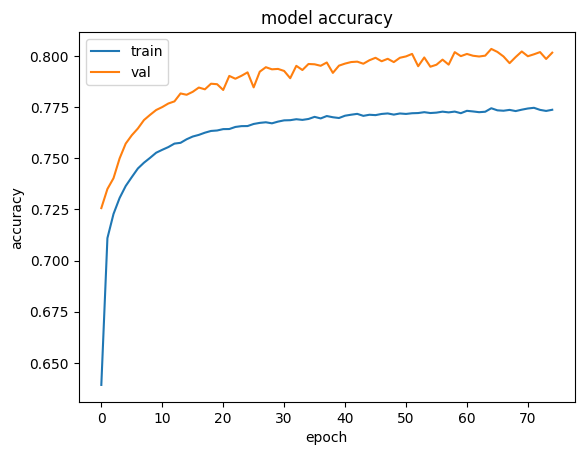

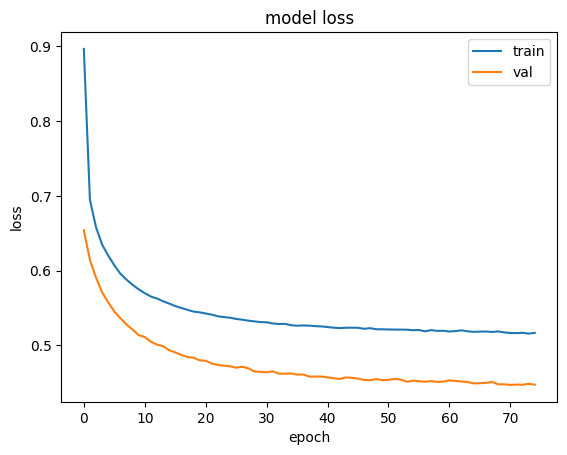

Test loss: 0.4485538899898529
Test accuracy: 0.8022339940071106
3632/3632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
3632/3632 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
                   precision    recall  f1-score   support

       Spruce/Fir       0.84      0.72      0.78     42368
   Lodgepole Pine       0.79      0.90      0.84     56661
   Ponderosa Pine       0.75      0.87      0.81      7151
Cottonwood/Willow       0.75      0.55      0.63       549
            Aspen       0.87      0.25      0.39      1899
      Douglas-fir       0.67      0.47      0.56      3473
        Krummholz       0.87      0.75      0.81      4102

         accuracy                           0.80    116203
        macro avg       0.79      0.65      0.69    116203
     weighted avg       0.81      0.80      0.80    116203

                   precision    recall  f1-score   support

       Spruce/Fir       0.84      0.72      0.78     42368
   Lodgepole Pine       0.79      0.90      0.84     56661
   Ponderosa Pine   

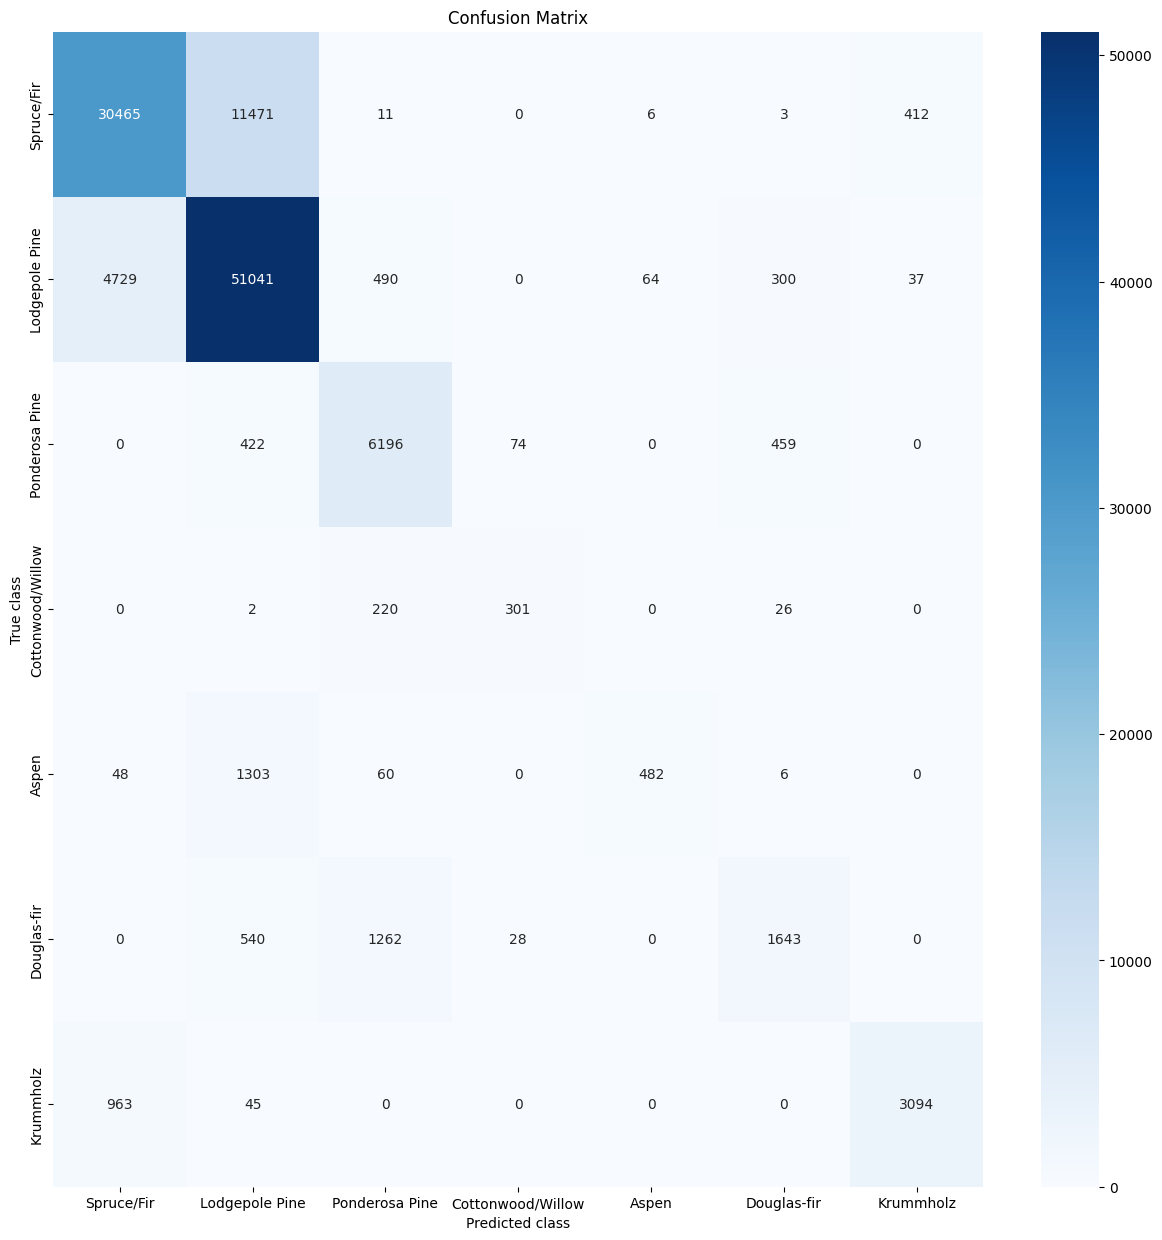

In [18]:
if __name__ == '__main__':
    main()

# Conclusions: 
The numbers along the diagonal of the heatmap show how many were correctly classified. All other numbers on either sides of the diagonal show mis-classifications. We see that Lodgepole Pine, Cottonwood Willow, Aspen, and Douglas-Fir suffer from a high percentage of mis-classifications.